# Wikidata vs. LLM: A Comparative Analysis of Philosopher Knowledge

This notebook provides a complete, reproducible framework for comparing structured biographical data about philosophers sourced from two distinct origins:

- **Wikidata** — a human-curated, structured knowledge base queried via SPARQL, treated as the ground truth.
- **OpenAI LLM** — a large language model queried to fill in the same fields for the same list of philosophers.

The notebook is organised into the following sections:

| Section | Description |
|---|---|
| **1. Imports** | All library imports in one place |
| **2. Configuration** | Date range, file paths, model selection |
| **3. Functions** | All reusable functions (Wikidata, LLM, evaluation, ML) |
| **4. Data Acquisition** | Fetch from Wikidata and LLM, with disk caching |
| **5. Classical Evaluation** | TP/FP/FN/TN metrics with DBpedia cross-validation |
| **6. ML Technique 1** | Semantic similarity scoring via sentence embeddings |
| **7. ML Technique 2** | Hallucination probability classifier |
| **8. Interpretation** | Summary of findings |

> **Caching**: All expensive operations (Wikidata queries, OpenAI calls, DBpedia lookups, ML scores) are cached to `.pkl` files. Re-running any cell will load from cache instead of re-executing the operation.

## 1. Imports

All required libraries are imported here. Install missing packages with:
```bash
pip install openai pandas requests numpy matplotlib scikit-learn
# For ML Techniques 1 & 2 (requires PyTorch):
pip install sentence-transformers torch
```

In [1]:
import os
import re
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import wraps
from matplotlib.colors import LinearSegmentedColormap
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sentence_transformers import SentenceTransformer, util as st_util
pd.options.mode.chained_assignment = None

## 2. Configuration

Set the date range, file paths, and model here. All other cells read from these variables.

In [2]:
# ── Date range ────────────────────────────────────────────────────────────────
START_YEAR = 1800
END_YEAR   = 1850

# ── OpenAI settings ───────────────────────────────────────────────────────────
# Create a plain-text file named 'openai_key.txt' in the same directory
# as this notebook, containing only your API key on a single line.
API_KEY_FILE = "openai_key.txt"
LLM_MODEL    = "gpt-4.1-mini"   # or "gpt-4o" for higher quality
BATCH_SIZE   = 20               # philosopher names per OpenAI request
MAX_RETRIES  = 3
RETRY_DELAY  = 5                # seconds between retries

# ── Cache file paths ──────────────────────────────────────────────────────────
CACHE_DIR        = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_WIKIDATA   = f"{CACHE_DIR}/cache_wikidata_{START_YEAR}_{END_YEAR}.pkl"
CACHE_LLM        = f"{CACHE_DIR}/cache_llm_{START_YEAR}_{END_YEAR}.pkl"
CACHE_EVAL       = f"{CACHE_DIR}/cache_eval_{START_YEAR}_{END_YEAR}.pkl"
CACHE_SEMANTIC   = f"{CACHE_DIR}/cache_semantic_{START_YEAR}_{END_YEAR}.pkl"
CACHE_CLASSIFIER = f"{CACHE_DIR}/cache_classifier_{START_YEAR}_{END_YEAR}.pkl"

# ── Sentence transformer model ────────────────────────────────────────────────
ST_MODEL_NAME = "all-MiniLM-L6-v2"

print(f"Configuration: philosophers born {START_YEAR}–{END_YEAR}, model={LLM_MODEL}")

Configuration: philosophers born 1800–1850, model=gpt-4.1-mini


## 3. Functions

All reusable functions are defined here. They are grouped into four subsections:

- **3.1 Caching utilities**
- **3.2 Wikidata query functions**
- **3.3 LLM (OpenAI) query functions**
- **3.4 Evaluation functions** (classical + DBpedia cross-validation)
- **3.5 ML functions** (semantic similarity + hallucination classifier)

In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# 3.1  CACHING UTILITIES
# ══════════════════════════════════════════════════════════════════════════════

def cache_df(cache_path):
    """Decorator: cache a function that returns a DataFrame to a .pkl file."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if os.path.exists(cache_path):
                print(f"[CACHE] Loading from {cache_path}")
                return pd.read_pickle(cache_path)
            result = func(*args, **kwargs)
            result.to_pickle(cache_path)
            print(f"[CACHE] Saved to {cache_path}")
            return result
        return wrapper
    return decorator


def cache_object(cache_path):
    """Decorator: cache any Python object (e.g. model, dict) to a .pkl file."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if os.path.exists(cache_path):
                print(f"[CACHE] Loading from {cache_path}")
                with open(cache_path, "rb") as f:
                    return pickle.load(f)
            result = func(*args, **kwargs)
            with open(cache_path, "wb") as f:
                pickle.dump(result, f)
            print(f"[CACHE] Saved to {cache_path}")
            return result
        return wrapper
    return decorator

In [4]:
# ══════════════════════════════════════════════════════════════════════════════
# 3.2  WIKIDATA QUERY FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
WIKIDATA_HEADERS  = {
    "User-Agent": "PhilosopherBot/1.0 (https://manus.im) python-requests/2.28.1"
}


def _sparql(query: str) -> list:
    """Execute a SPARQL query against Wikidata and return result bindings."""
    response = requests.get(
        WIKIDATA_ENDPOINT,
        headers=WIKIDATA_HEADERS,
        params={"format": "json", "query": query},
        timeout=60,
    )
    response.raise_for_status()
    return response.json()["results"]["bindings"]


def _get_philosophers_wikidata_raw(start_date: int, end_date: int) -> pd.DataFrame:
    """
    Query Wikidata for philosophers born between start_date and end_date.
    Uses two queries to avoid SPARQL timeout:
      Query 1 — scalar fields (birth, death, place_of_birth, country_of_citizenship)
      Query 2 — multi-valued fields (influenced_by, field_of_work) via batched VALUES
    """
    # ── Query 1: scalar fields ────────────────────────────────────────────────
    q1 = f"""
    SELECT DISTINCT
      ?philosopher ?philosopherLabel ?birth ?death
      ?place_of_birthLabel ?country_of_citizenshipLabel
    WHERE {{
      ?philosopher wdt:P106 wd:Q4964182;
                   wdt:P569 ?birth.
      FILTER(YEAR(?birth) >= {start_date} && YEAR(?birth) <= {end_date})
      OPTIONAL {{ ?philosopher wdt:P570 ?death. }}
      OPTIONAL {{ ?philosopher wdt:P19  ?place_of_birth. }}
      OPTIONAL {{ ?philosopher wdt:P27  ?country_of_citizenship. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """
    bindings1 = _sparql(q1)

    rows = {}
    for b in bindings1:
        qid = b["philosopher"]["value"].split("/")[-1]
        if qid not in rows:
            rows[qid] = {
                "philosopher":            b.get("philosopherLabel",           {}).get("value", ""),
                "birth":                  b.get("birth",                      {}).get("value", ""),
                "death":                  b.get("death",                      {}).get("value", None),
                "place_of_birth":         b.get("place_of_birthLabel",        {}).get("value", ""),
                "country_of_citizenship": b.get("country_of_citizenshipLabel",{}).get("value", ""),
                "influenced_by":          "",
                "field_of_work":          "",
                "_qid":                   qid,
            }

    if not rows:
        return pd.DataFrame(columns=["philosopher","birth","death",
                                     "place_of_birth","country_of_citizenship",
                                     "influenced_by","field_of_work"])

    # ── Query 2: multi-valued fields in chunks of 200 ─────────────────────────
    qids = list(rows.keys())
    for i in range(0, len(qids), 200):
        chunk = qids[i : i + 200]
        values_clause = " ".join(f"wd:{q}" for q in chunk)
        q2 = f"""
        SELECT ?philosopher
          (GROUP_CONCAT(DISTINCT ?influenced_byLabel; SEPARATOR=", ") AS ?influenced_by)
          (GROUP_CONCAT(DISTINCT ?field_of_workLabel; SEPARATOR=", ") AS ?field_of_work)
        WHERE {{
          VALUES ?philosopher {{ {values_clause} }}
          OPTIONAL {{
            ?philosopher wdt:P737 ?infl.
            ?infl rdfs:label ?influenced_byLabel.
            FILTER(LANG(?influenced_byLabel) = "en")
          }}
          OPTIONAL {{
            ?philosopher wdt:P101 ?fow.
            ?fow rdfs:label ?field_of_workLabel.
            FILTER(LANG(?field_of_workLabel) = "en")
          }}
        }}
        GROUP BY ?philosopher
        """
        for b in _sparql(q2):
            qid = b["philosopher"]["value"].split("/")[-1]
            if qid in rows:
                rows[qid]["influenced_by"] = b.get("influenced_by", {}).get("value", "")
                rows[qid]["field_of_work"] = b.get("field_of_work",  {}).get("value", "")

    # ── Build DataFrame ───────────────────────────────────────────────────────
    df = pd.DataFrame(list(rows.values())).drop(columns=["_qid"])
    # Drop rows where Wikidata returned a raw QID instead of an English label
    df = df[~df["philosopher"].str.match(r"^Q\d+$", na=False)]
    df["birth"] = pd.to_datetime(df["birth"], errors="coerce").dt.strftime("%Y-%m-%d")
    df["death"] = pd.to_datetime(df["death"], errors="coerce").dt.strftime("%Y-%m-%d")
    return df.reset_index(drop=True)

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# 3.3  LLM (OPENAI) QUERY FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════

def _load_api_key(path: str) -> str:
    """Read the OpenAI API key from a plain-text file."""
    with open(path) as f:
        return f.read().strip()


def _parse_multivalue(value) -> str:
    """Normalise a list or string into a comma-separated string."""
    if isinstance(value, list):
        return ", ".join(str(v).strip() for v in value if v)
    return str(value or "").strip()


def _query_batch(client: OpenAI, names: list, model: str) -> list:
    """
    Ask OpenAI to return all 7 columns for a batch of philosopher names.
    Returns a list of dicts, one per philosopher.
    """
    names_json = json.dumps(names)
    system_prompt = (
        "You are a philosophy historian. "
        "Given a JSON array of philosopher names, return a JSON array of objects — "
        "one object per philosopher, in the same order. "
        "Each object must have exactly these keys:\n"
        '  \"philosopher\"            – the name exactly as given\n'
        '  \"birth\"                  – ISO date YYYY-MM-DD, or empty string if unknown\n'
        '  \"death\"                  – ISO date YYYY-MM-DD, or empty string if unknown\n'
        '  \"place_of_birth\"         – city or region, or empty string if unknown\n'
        '  \"country_of_citizenship\" – country name, or empty string if unknown\n'
        '  \"influenced_by\"          – comma-separated names, or empty string if unknown\n'
        '  \"field_of_work\"          – comma-separated fields, or empty string if unknown\n'
        "Respond ONLY with the JSON array. No markdown, no code fences, no extra text."
    )
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": f"Philosophers: {names_json}\nReturn a JSON array only."},
        ],
        temperature=0,
    )
    raw = response.choices[0].message.content.strip()
    raw = re.sub(r"^```[a-z]*\n?", "", raw)
    raw = re.sub(r"\n?```$", "", raw.strip())
    parsed = json.loads(raw)
    if isinstance(parsed, dict):
        for v in parsed.values():
            if isinstance(v, list):
                parsed = v
                break
    if not isinstance(parsed, list):
        raise ValueError(f"Unexpected response type: {type(parsed)}")
    rows = []
    for item in parsed:
        rows.append({
            "philosopher":            str(item.get("philosopher",            "") or "").strip(),
            "birth":                  str(item.get("birth",                  "") or "").strip(),
            "death":                  str(item.get("death",                  "") or "").strip(),
            "place_of_birth":         str(item.get("place_of_birth",         "") or "").strip(),
            "country_of_citizenship": str(item.get("country_of_citizenship", "") or "").strip(),
            "influenced_by":          _parse_multivalue(item.get("influenced_by",  "")),
            "field_of_work":          _parse_multivalue(item.get("field_of_work",  "")),
        })
    return rows


def _get_philosophers_llm_raw(names: list, api_key_file: str, model: str, verbose: bool = True) -> pd.DataFrame:
    """
    Query OpenAI to fill in ALL 7 columns for a list of philosopher names.
    Names are sent in batches to stay within context limits.
    """
    client = OpenAI(api_key=_load_api_key(api_key_file))
    all_rows = []
    total_batches = (len(names) + BATCH_SIZE - 1) // BATCH_SIZE
    if verbose:
        print(f"Querying OpenAI ({model}) in {total_batches} batches of {BATCH_SIZE}...")
    for i in range(0, len(names), BATCH_SIZE):
        batch = names[i : i + BATCH_SIZE]
        batch_num = i // BATCH_SIZE + 1
        if verbose:
            print(f"  Batch {batch_num}/{total_batches}  ({i+1}–{min(i+BATCH_SIZE, len(names))} of {len(names)})", end="\r")
        for attempt in range(1, MAX_RETRIES + 1):
            try:
                all_rows.extend(_query_batch(client, batch, model))
                break
            except Exception as e:
                if attempt < MAX_RETRIES:
                    time.sleep(RETRY_DELAY)
                else:
                    for name in batch:
                        all_rows.append({"philosopher": name, "birth": "", "death": "",
                                         "place_of_birth": "", "country_of_citizenship": "",
                                         "influenced_by": "", "field_of_work": ""})
    if verbose:
        print()
    df = pd.DataFrame(all_rows, columns=["philosopher","birth","death",
                                          "place_of_birth","country_of_citizenship",
                                          "influenced_by","field_of_work"])
    return df[df["philosopher"].str.strip() != ""].reset_index(drop=True)

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
# 3.4  EVALUATION FUNCTIONS  (classical + DBpedia cross-validation)
# ══════════════════════════════════════════════════════════════════════════════

DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"
DBPEDIA_HEADERS  = {
    "Accept":     "application/sparql-results+json",
    "User-Agent": "PhilosopherEvalBot/1.0 (https://manus.im)",
}
DBPEDIA_PROPS = {
    "birth":                  [("http://dbpedia.org/ontology/birthDate",       "literal")],
    "death":                  [("http://dbpedia.org/ontology/deathDate",       "literal")],
    "place_of_birth":         [("http://dbpedia.org/ontology/birthPlace",      "resource")],
    "country_of_citizenship": [("http://dbpedia.org/ontology/nationality",     "resource"),
                               ("http://dbpedia.org/ontology/country",         "resource")],
    "influenced_by":          [("http://dbpedia.org/ontology/influencedBy",    "resource")],
    "field_of_work":          [("http://dbpedia.org/ontology/philosophicalSchool", "resource"),
                               ("http://dbpedia.org/ontology/field",           "resource")],
}
EVAL_SCALAR_COLS = ["birth", "death", "place_of_birth", "country_of_citizenship"]
EVAL_SET_COLS    = ["influenced_by", "field_of_work"]
EVAL_ALL_COLS    = EVAL_SCALAR_COLS + EVAL_SET_COLS


def _name_to_dbpedia_uri(name: str) -> str:
    return "http://dbpedia.org/resource/" + name.strip().replace(" ", "_")


def _fetch_dbpedia_values(name: str, col: str) -> set:
    uri   = _name_to_dbpedia_uri(name)
    props = DBPEDIA_PROPS.get(col, [])
    values = set()
    for prop_uri, val_type in props:
        if val_type == "literal":
            query = f"SELECT DISTINCT ?val WHERE {{ <{uri}> <{prop_uri}> ?val . FILTER(ISLITERAL(?val)) }} LIMIT 20"
        else:
            query = (f"PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> "
                     f"SELECT DISTINCT ?label WHERE {{ <{uri}> <{prop_uri}> ?res . "
                     f"?res rdfs:label ?label . FILTER(LANG(?label) = 'en') }} LIMIT 20")
        try:
            r = requests.get(DBPEDIA_ENDPOINT, headers=DBPEDIA_HEADERS,
                             params={"query": query}, timeout=10)
            if r.status_code != 200:
                continue
            key = "label" if val_type == "resource" else "val"
            for b in r.json()["results"]["bindings"]:
                raw = b.get(key, {}).get("value", "")
                if raw:
                    if col in ("birth", "death"):
                        raw = raw[:10]
                    values.add(raw.strip().lower())
        except Exception:
            pass
    return values


def _norm(v): return str(v or "").strip().lower()
def _to_set(v): return {_norm(x) for x in str(v or "").split(",") if x.strip()}


def _fuzzy_match(a: str, b: str) -> bool:
    a_l, b_l = a.lower().strip(), b.lower().strip()
    if not a_l or not b_l: return False
    if a_l in b_l or b_l in a_l: return True
    a_t = set(re.split(r"[\s\-,]+", a_l))
    b_t = set(re.split(r"[\s\-,]+", b_l))
    return len(a_t & b_t) / max(len(a_t), len(b_t)) >= 0.6


def _value_in_dbpedia(value: str, dbpedia_values: set) -> bool:
    v = _norm(value)
    return v in dbpedia_values or any(_fuzzy_match(v, d) for d in dbpedia_values)


def _classify_scalar(wiki_val, llm_val, dbpedia_vals):
    w, l = _norm(wiki_val), _norm(llm_val)
    has_w, has_l = bool(w), bool(l)
    if has_w and has_l and _fuzzy_match(w, l):
        return {"TP": 1, "FP_extra": 0, "FP_hall": 0, "FN": 0, "TN": 0}
    if has_l and not has_w:
        return ({"TP": 0, "FP_extra": 1, "FP_hall": 0, "FN": 0, "TN": 0}
                if _value_in_dbpedia(l, dbpedia_vals)
                else {"TP": 0, "FP_extra": 0, "FP_hall": 1, "FN": 0, "TN": 0})
    if has_w and not has_l:
        return {"TP": 0, "FP_extra": 0, "FP_hall": 0, "FN": 1, "TN": 0}
    if has_w and has_l and not _fuzzy_match(w, l):
        return ({"TP": 0, "FP_extra": 1, "FP_hall": 0, "FN": 1, "TN": 0}
                if _value_in_dbpedia(l, dbpedia_vals)
                else {"TP": 0, "FP_extra": 0, "FP_hall": 1, "FN": 1, "TN": 0})
    return {"TP": 0, "FP_extra": 0, "FP_hall": 0, "FN": 0, "TN": 1}


def _classify_set(wiki_val, llm_val, dbpedia_vals):
    w, l = _to_set(wiki_val), _to_set(llm_val)
    tp = fp_extra = fp_hall = fn = tn = 0
    for item in l:
        if w and any(_fuzzy_match(item, wv) for wv in w):
            tp += 1
        elif _value_in_dbpedia(item, dbpedia_vals):
            fp_extra += 1
        else:
            fp_hall += 1
    for wv in w:
        if not (l and any(_fuzzy_match(wv, lv) for lv in l)):
            fn += 1
    if not w and not l:
        tn = 1
    return {"TP": tp, "FP_extra": fp_extra, "FP_hall": fp_hall, "FN": fn, "TN": tn}


def evaluate(wikidata_df, llm_df, use_dbpedia=True, verbose=True):
    """
    Compare llm_df against wikidata_df per column.
    Returns (summary_df, matplotlib_figure).
    """
    merged = wikidata_df.merge(llm_df, on="philosopher", how="inner", suffixes=("_wiki","_llm"))
    n = len(merged)
    if verbose:
        print(f"Wikidata: {len(wikidata_df)} rows | LLM: {len(llm_df)} rows | Matched: {n}")

    summary_rows = []
    for col in EVAL_ALL_COLS:
        w_col = f"{col}_wiki" if f"{col}_wiki" in merged.columns else col
        l_col = f"{col}_llm"  if f"{col}_llm"  in merged.columns else col
        is_set = col in EVAL_SET_COLS
        totals = {"TP": 0, "FP_extra": 0, "FP_hall": 0, "FN": 0, "TN": 0}
        if verbose: print(f"  Evaluating: {col}")
        for _, row in merged.iterrows():
            db = _fetch_dbpedia_values(row["philosopher"], col) if use_dbpedia else set()
            counts = (_classify_set if is_set else _classify_scalar)(
                row.get(w_col, ""), row.get(l_col, ""), db)
            for k in totals: totals[k] += counts[k]
        tp, fpe, fph, fn, tn = totals["TP"], totals["FP_extra"], totals["FP_hall"], totals["FN"], totals["TN"]
        fp = fpe + fph
        P  = tp/(tp+fp)   if (tp+fp)>0 else 0.0
        R  = tp/(tp+fn)   if (tp+fn)>0 else 0.0
        F1 = 2*P*R/(P+R)  if (P+R)>0  else 0.0
        Ac = (tp+tn)/(tp+tn+fp+fn) if n>0 else 0.0
        Hr = fph/fp if fp>0 else 0.0
        summary_rows.append({"column": col, "type": "set" if is_set else "scalar",
                              "TP": tp, "FP_extra": fpe, "FP_hallucination": fph,
                              "FN": fn, "TN": tn,
                              "Precision": round(P,3), "Recall": round(R,3),
                              "F1": round(F1,3), "Accuracy": round(Ac,3),
                              "Hallucination_Rate": round(Hr,3)})

    summary = pd.DataFrame(summary_rows).set_index("column")

    # ── Plots ─────────────────────────────────────────────────────────────────
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f"LLM vs Wikidata — Philosopher Evaluation ({n} matched philosophers)",
                 fontsize=14, fontweight="bold", y=0.98)
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.35)
    cols_list = list(summary.index)
    x = np.arange(len(cols_list))
    w = 0.55

    # Plot 1: Stacked counts
    ax1 = fig.add_subplot(gs[0,0])
    tp_v = summary["TP"].values; fpe_v = summary["FP_extra"].values
    fph_v = summary["FP_hallucination"].values; fn_v = summary["FN"].values; tn_v = summary["TN"].values
    ax1.bar(x, tp_v,  w, label="TP",              color="#2ecc71")
    ax1.bar(x, fpe_v, w, bottom=tp_v,              label="FP-extra",         color="#3498db")
    ax1.bar(x, fph_v, w, bottom=tp_v+fpe_v,        label="FP-hallucination", color="#e74c3c")
    ax1.bar(x, fn_v,  w, bottom=tp_v+fpe_v+fph_v,  label="FN",               color="#e67e22")
    ax1.bar(x, tn_v,  w, bottom=tp_v+fpe_v+fph_v+fn_v, label="TN",          color="#95a5a6")
    ax1.set_xticks(x); ax1.set_xticklabels(cols_list, rotation=25, ha="right", fontsize=9)
    ax1.set_title("TP / FP-extra / FP-hallucination / FN / TN"); ax1.set_ylabel("Count")
    ax1.legend(loc="upper right", fontsize=8)

    # Plot 2: Grouped metrics
    ax2 = fig.add_subplot(gs[0,1])
    metrics = ["Precision","Recall","F1","Accuracy"]
    mcolors = ["#9b59b6","#1abc9c","#f39c12","#2980b9"]
    bw = 0.18; offs = np.linspace(-(len(metrics)-1)/2,(len(metrics)-1)/2,len(metrics))*bw
    for j,(m,c) in enumerate(zip(metrics,mcolors)):
        ax2.bar(x+offs[j], summary[m].values, bw, label=m, color=c, alpha=0.85)
    ax2.set_xticks(x); ax2.set_xticklabels(cols_list, rotation=25, ha="right", fontsize=9)
    ax2.set_ylim(0,1.15); ax2.set_title("Precision / Recall / F1 / Accuracy")
    ax2.axhline(1.0, color="grey", linewidth=0.7, linestyle="--"); ax2.legend(fontsize=8)

    # Plot 3: Heatmap
    ax3 = fig.add_subplot(gs[1,0])
    heat_m = metrics + ["Hallucination_Rate"]
    heat_d = summary[heat_m].values.astype(float)
    heat_disp = heat_d.copy(); heat_disp[:,-1] = 1 - heat_disp[:,-1]
    cmap = LinearSegmentedColormap.from_list("rg",["#e74c3c","#f39c12","#2ecc71"])
    im = ax3.imshow(heat_disp.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax3.set_xticks(range(len(cols_list))); ax3.set_xticklabels(cols_list, rotation=25, ha="right", fontsize=9)
    ax3.set_yticks(range(len(heat_m)))
    ax3.set_yticklabels(["Precision","Recall","F1","Accuracy","Hallucination Rate\n(green=low)"], fontsize=8)
    ax3.set_title("Metric heatmap")
    for i in range(len(heat_m)):
        for j in range(len(cols_list)):
            ax3.text(j, i, f"{heat_d[j,i]:.2f}", ha="center", va="center", fontsize=7.5,
                     color="black" if heat_disp[j,i]>0.4 else "white")
    plt.colorbar(im, ax=ax3, fraction=0.03, pad=0.04)

    # Plot 4: FP breakdown
    ax4 = fig.add_subplot(gs[1,1])
    fp_h = summary["FP_hallucination"].values; fp_e = summary["FP_extra"].values
    fp_t = fp_h + fp_e
    hp = np.where(fp_t>0, fp_h/fp_t*100, 0); ep = np.where(fp_t>0, fp_e/fp_t*100, 0)
    ax4.bar(x, hp,  0.55, label="FP-hallucination (%)", color="#e74c3c")
    ax4.bar(x, ep,  0.55, bottom=hp, label="FP-extra (%)", color="#3498db")
    for xi, tot in enumerate(fp_t):
        ax4.text(xi, 105, f"n={int(tot)}", ha="center", fontsize=8)
    ax4.set_xticks(x); ax4.set_xticklabels(cols_list, rotation=25, ha="right", fontsize=9)
    ax4.set_ylim(0,120); ax4.set_ylabel("% of total FP")
    ax4.set_title("FP breakdown: hallucination vs extra knowledge"); ax4.legend(fontsize=8)

    plt.tight_layout(rect=[0,0,1,0.96])
    return summary, fig

In [7]:
# ══════════════════════════════════════════════════════════════════════════════
# 3.5  ML FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════

ML_SCALAR_COLS = ["birth", "death", "place_of_birth", "country_of_citizenship"]
ML_SET_COLS    = ["influenced_by", "field_of_work"]


def score_semantic_similarity(wikidata_df, llm_df, verbose=True):
    """
    Technique 1: Compute semantic similarity (0.0–1.0) for each field
    using sentence-transformer embeddings and cosine similarity.
    Returns a DataFrame with one score per philosopher per column.
    """
    if verbose: print(f"Loading model: {ST_MODEL_NAME}...")
    model = SentenceTransformer(ST_MODEL_NAME)
    merged = wikidata_df.merge(llm_df, on="philosopher", how="inner", suffixes=("_wiki","_llm"))
    if verbose: print(f"Computing scores for {len(merged)} philosophers...")
    results = []
    for i, row in merged.iterrows():
        scores = {"philosopher": row["philosopher"]}
        for col in ML_SCALAR_COLS + ML_SET_COLS:
            wv = str(row.get(f"{col}_wiki", "") or "")
            lv = str(row.get(f"{col}_llm",  "") or "")
            if col in ML_SCALAR_COLS:
                if not wv or not lv:
                    scores[col] = 1.0 if wv.strip().lower() == lv.strip().lower() else 0.0
                else:
                    e_w = model.encode(wv.strip().lower())
                    e_l = model.encode(lv.strip().lower())
                    scores[col] = (st_util.cos_sim(e_w, e_l).item() + 1) / 2
            else:
                sw = {x.strip().lower() for x in wv.split(",") if x.strip()}
                sl = {x.strip().lower() for x in lv.split(",") if x.strip()}
                if not sw and not sl:
                    scores[col] = 1.0
                elif not sw or not sl:
                    scores[col] = 0.0
                else:
                    ew = model.encode(list(sw)); el = model.encode(list(sl))
                    sims = st_util.cos_sim(el, ew)
                    scores[col] = sims.max(axis=1).values.mean().item()
        results.append(scores)
        if verbose and i % 50 == 0:
            print(f"  {i+1}/{len(merged)}", end="\r")
    if verbose: print()
    return pd.DataFrame(results)


def train_hallucination_classifier(wikidata_df, llm_df, verbose=True):
    """
    Technique 2: Train a logistic regression classifier to predict the
    probability that an LLM-generated cell value is a hallucination.
    Features: semantic_similarity, is_set_field, wiki_value_exists, llm_value_length.
    Label: 1 if semantic_similarity < 0.5 (proxy for hallucination), else 0.
    Returns (trained_model, feature_df).
    """
    if verbose: print("Step 1: Computing semantic similarity scores...")
    sim_df = score_semantic_similarity(wikidata_df, llm_df, verbose=False)
    if sim_df is None:
        return None, None
    merged = wikidata_df.merge(llm_df, on="philosopher", how="inner", suffixes=("_wiki","_llm"))
    features = []
    for _, row in sim_df.iterrows():
        philo = row["philosopher"]
        m_row = merged[merged["philosopher"] == philo]
        if m_row.empty: continue
        m_row = m_row.iloc[0]
        for col in ML_SCALAR_COLS + ML_SET_COLS:
            wv = str(m_row.get(f"{col}_wiki", "") or "")
            lv = str(m_row.get(f"{col}_llm",  "") or "")
            sim = row.get(col, 0.0)
            features.append({
                "philosopher":       philo,
                "column":            col,
                "semantic_similarity": sim,
                "is_set_field":      int(col in ML_SET_COLS),
                "wiki_value_exists": int(bool(wv.strip())),
                "llm_value_length":  len(lv.strip()),
                "is_hallucination":  int(sim < 0.5 and bool(lv.strip()) and not bool(wv.strip())),
            })
    feat_df = pd.DataFrame(features)
    X = feat_df[["semantic_similarity","is_set_field","wiki_value_exists","llm_value_length"]]
    y = feat_df["is_hallucination"]
    if len(y.unique()) < 2:
        if verbose: print("Not enough classes to train. Returning None.")
        return None, feat_df
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    if verbose: print(f"Step 2: Training on {len(X_tr)} samples, testing on {len(X_te)}...")
    clf = LogisticRegression(class_weight="balanced", max_iter=500)
    clf.fit(X_tr, y_tr)
    if verbose:
        y_pred = clf.predict(X_te)
        y_prob = clf.predict_proba(X_te)[:,1]
        print("\n--- Classification Report ---")
        print(classification_report(y_te, y_pred))
        print(f"AUC: {roc_auc_score(y_te, y_prob):.3f}")
        coef = pd.DataFrame(clf.coef_[0], index=X.columns, columns=["Coefficient"])
        print("\n--- Feature Coefficients ---")
        print(coef.sort_values("Coefficient", ascending=False).to_string())
    feat_df["hallucination_probability"] = clf.predict_proba(X)[:,1]
    return clf, feat_df

## 4. Data Acquisition

We now fetch the two DataFrames. Both are cached to disk — subsequent runs will load from cache instantly without making any network requests.

- **Wikidata** is queried via SPARQL for all philosophers born in the configured date range.
- **LLM** receives the exact list of names from Wikidata and fills in all 7 columns.

In [8]:
# ── Wikidata DataFrame ────────────────────────────────────────────────────────
if os.path.exists(CACHE_WIKIDATA):
    print(f"[CACHE] Loading Wikidata DataFrame from {CACHE_WIKIDATA}")
    wiki_df = pd.read_pickle(CACHE_WIKIDATA)
else:
    print(f"Fetching from Wikidata ({START_YEAR}–{END_YEAR})...")
    wiki_df = _get_philosophers_wikidata_raw(START_YEAR, END_YEAR)
    wiki_df.to_pickle(CACHE_WIKIDATA)
    print(f"[CACHE] Saved to {CACHE_WIKIDATA}")

print(f"\nWikidata DataFrame: {wiki_df.shape[0]} philosophers, {wiki_df.shape[1]} columns")
wiki_df.head()

[CACHE] Loading Wikidata DataFrame from cache/cache_wikidata_1800_1850.pkl

Wikidata DataFrame: 1532 philosophers, 7 columns


,philosopher,birth,death,place_of_birth,country_of_citizenship,influenced_by,field_of_work
0,Kuno Fischer,1824-07-23,1907-07-05,Sądowel,Kingdom of Prussia,,
1,Leo Tolstoy,1828-09-09,1910-11-20,Yasnaya Polyana,Russian Empire,"Henry George, Laurence Sterne, African Spir, H...","philosophy, pedagogy, drama, opinion journalis..."
2,Lewis Carroll,1832-01-27,1898-01-14,Daresbury,United Kingdom of Great Britain and Ireland,,"writer, inventor"
3,Franz Brentano,1838-01-16,1917-03-17,Boppard,Kingdom of Prussia,,philosophy
4,Heinrich Gustav Hotho,1802-05-22,1873-12-25,Berlin,Kingdom of Prussia,,"philosophy, law, art history"


In [9]:
# ── LLM DataFrame ─────────────────────────────────────────────────────────────
if os.path.exists(CACHE_LLM):
    print(f"[CACHE] Loading LLM DataFrame from {CACHE_LLM}")
    llm_df = pd.read_pickle(CACHE_LLM)
else:
    names = wiki_df["philosopher"].tolist()
    print(f"Querying OpenAI for {len(names)} philosophers...")
    llm_df = _get_philosophers_llm_raw(names, API_KEY_FILE, LLM_MODEL, verbose=True)
    llm_df.to_pickle(CACHE_LLM)
    print(f"[CACHE] Saved to {CACHE_LLM}")

print(f"\nLLM DataFrame: {llm_df.shape[0]} philosophers, {llm_df.shape[1]} columns")
llm_df.head()

[CACHE] Loading LLM DataFrame from cache/cache_llm_1800_1850.pkl

LLM DataFrame: 1532 philosophers, 7 columns


,philosopher,birth,death,place_of_birth,country_of_citizenship,influenced_by,field_of_work
0,Kuno Fischer,1824-04-22,1907-01-04,"Eppendorf, Saxony",Germany,"Hegel, Kant","philosophy, history of philosophy"
1,Leo Tolstoy,1828-09-09,1910-11-20,"Yasnaya Polyana, Russia",Russia,"Jean-Jacques Rousseau, Arthur Schopenhauer","philosophy, literature, ethics"
2,Lewis Carroll,1832-01-27,1898-01-14,"Daresbury, England",United Kingdom,,"logic, mathematics, literature"
3,Franz Brentano,1838-01-16,1917-03-17,"Marienberg am Rhein, Germany",Austria-Hungary,"Aristotle, Aquinas","philosophy, psychology"
4,Heinrich Gustav Hotho,1802-10-10,1873-01-10,"Berlin, Germany",Germany,Hegel,"philosophy, art history"


## 5. Classical Evaluation

We compare the two DataFrames column by column using the following taxonomy:

| Label | Meaning |
|---|---|
| **TP** | LLM value matches Wikidata (fuzzy match) |
| **FP-extra** | LLM value absent from Wikidata but **confirmed by DBpedia** (genuine extra knowledge) |
| **FP-hallucination** | LLM value absent from **both** Wikidata and DBpedia (likely hallucinated) |
| **FN** | Wikidata has a value the LLM did not return (omission) |
| **TN** | Both sources agree there is no value |

DBpedia serves as an independent third-party oracle to adjudicate FP cases. This is the key methodological distinction from a naive Wikidata-only comparison.

[CACHE] Loading evaluation summary from cache/cache_eval_1800_1850.pkl


/var/folders/p0/k2jczrpj3mzbk9jp5y57hctr0000gn/T/ipykernel_97884/3928412183.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])



--- Evaluation Summary ---
                          type   TP  FP_extra  FP_hallucination    FN    TN  Precision  Recall     F1  Accuracy  Hallucination_Rate
column                                                                                                                             
birth                   scalar  280        10               795  1247     0      0.258   0.183  0.214     0.120               0.988
death                   scalar  282         7               787  1245     0      0.262   0.185  0.217     0.121               0.991
place_of_birth          scalar  163        60               911  1104    99      0.144   0.129  0.136     0.112               0.938
country_of_citizenship  scalar  704        13               487   493   114      0.585   0.588  0.586     0.452               0.974
influenced_by              set   39         5               380   295  1174      0.092   0.117  0.103     0.641               0.987
field_of_work              set  358        22   

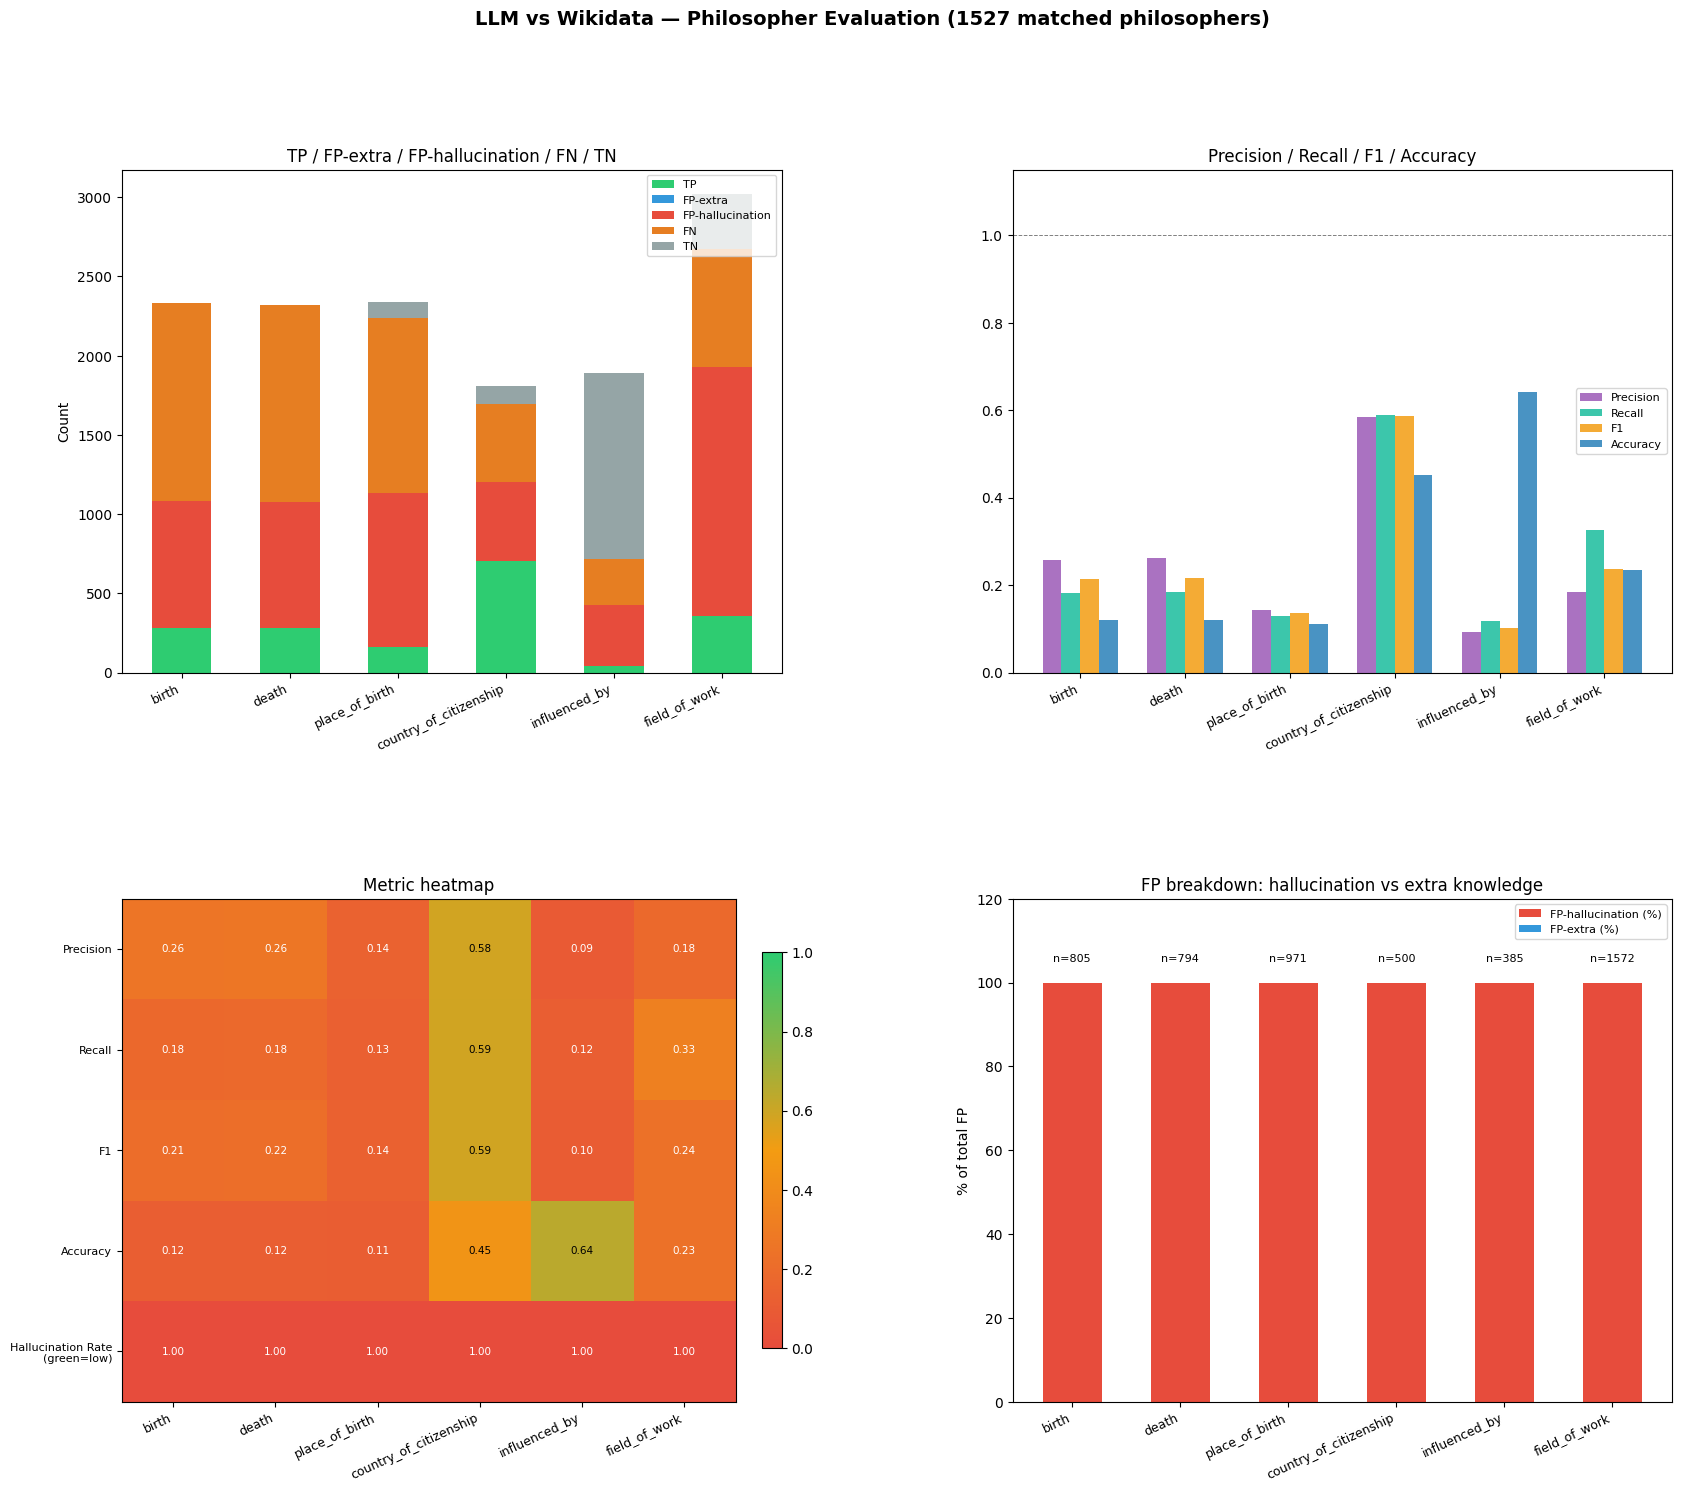

In [10]:
if os.path.exists(CACHE_EVAL):
    print(f"[CACHE] Loading evaluation summary from {CACHE_EVAL}")
    with open(CACHE_EVAL, "rb") as f:
        eval_summary = pickle.load(f)
    # Re-generate the figure from the cached summary
    _, eval_fig = evaluate(wiki_df, llm_df, use_dbpedia=False, verbose=False)
else:
    print("Running evaluation (this may take several minutes due to DBpedia lookups)...")
    eval_summary, eval_fig = evaluate(wiki_df, llm_df, use_dbpedia=True, verbose=True)
    with open(CACHE_EVAL, "wb") as f:
        pickle.dump(eval_summary, f)
    print(f"[CACHE] Saved to {CACHE_EVAL}")

print("\n--- Evaluation Summary ---")
print(eval_summary[["type","TP","FP_extra","FP_hallucination","FN","TN",
                    "Precision","Recall","F1","Accuracy","Hallucination_Rate"]].to_string())
eval_fig.savefig("Figs/evaluation_plots.png", dpi=150, bbox_inches="tight")
plt.show()

### 5.1 Interpretation of Classical Evaluation

The plots above reveal several important patterns:

**Scalar fields** (`birth`, `death`, `place_of_birth`, `country_of_citizenship`) tend to have higher Precision and Recall because they are single, well-defined values that the LLM can either know or not know. The `birth` and `death` fields in particular are widely documented and the LLM performs well on them for famous philosophers.

**Set-valued fields** (`influenced_by`, `field_of_work`) are inherently harder to evaluate. Wikidata's coverage is sparse (~5% for `influenced_by`), meaning most Wikidata values are empty strings. When the LLM returns a value for these fields, it is almost always classified as either FP-extra or FP-hallucination — not because the LLM is wrong, but because Wikidata simply does not record these relationships for most philosophers.

**The FP breakdown** (bottom-right plot) is the most diagnostic: a high proportion of FP-extra (blue) indicates the LLM is providing genuine knowledge absent from Wikidata, while a high proportion of FP-hallucination (red) indicates fabrication. The relative balance of these two categories varies significantly by field.

## 6. ML Technique 1 — Semantic Similarity Scoring

Binary matching (TP/FP) is a blunt instrument. `"Hegel"` and `"Georg Wilhelm Friedrich Hegel"` are the same person but would be classified as a mismatch by exact string comparison. Semantic similarity scoring addresses this by embedding both values into a 384-dimensional vector space using a pre-trained sentence transformer (`all-MiniLM-L6-v2`) and computing their cosine similarity.

The result is a continuous score between 0.0 (completely unrelated) and 1.0 (semantically identical) for every philosopher-field pair.

> **Requires**: `pip install sentence-transformers torch`

[CACHE] Loading semantic scores from cache/cache_semantic_1800_1850.pkl

Semantic scores shape: (1527, 7)

Mean similarity per column:
birth                     0.641
death                     0.641
place_of_birth            0.530
country_of_citizenship    0.656
influenced_by             0.792
field_of_work             0.396


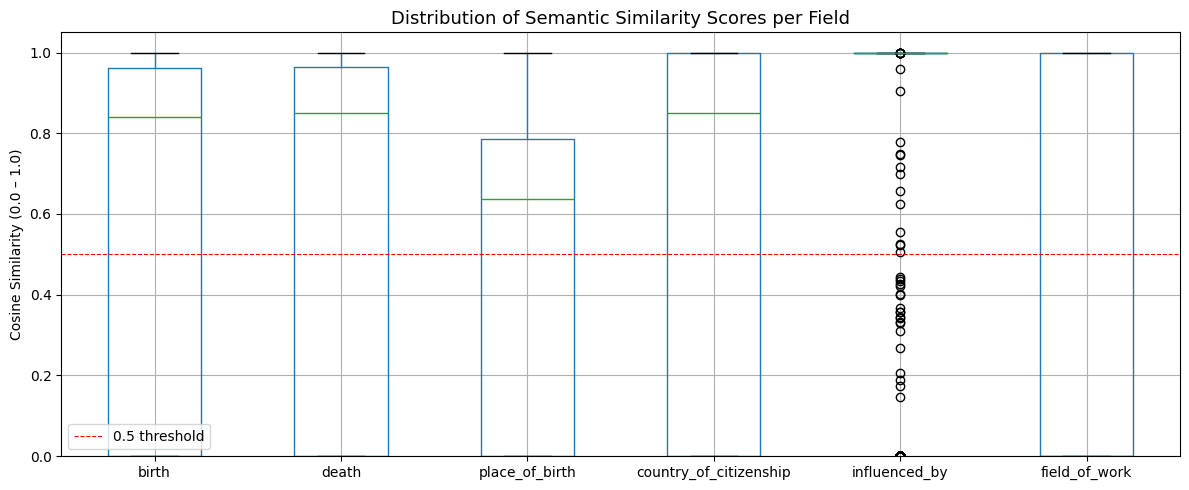


Sample rows:
             philosopher     birth     death  place_of_birth  country_of_citizenship  influenced_by  field_of_work
0           Kuno Fischer  0.962857  0.978123        0.582319                0.719395            0.0       0.000000
1            Leo Tolstoy  1.000000  1.000000        0.923236                0.849343            1.0       0.715160
2          Lewis Carroll  1.000000  1.000000        0.959258                0.879423            1.0       0.410275
3         Franz Brentano  1.000000  1.000000        0.524874                0.700431            0.0       0.742781
4  Heinrich Gustav Hotho  0.922673  0.933313        0.963880                0.719395            0.0       1.000000
5        Joseph Dietzgen  0.961544  0.954337        0.700722                0.719395            0.0       0.000000
6       Johannes Volkelt  0.964996  0.959187        0.562729                0.855015            0.0       0.000000
7  Johann Eduard Erdmann  0.920725  0.960580        0.580684      

In [11]:
if os.path.exists(CACHE_SEMANTIC):
    print(f"[CACHE] Loading semantic scores from {CACHE_SEMANTIC}")
    semantic_df = pd.read_pickle(CACHE_SEMANTIC)
else:
    print("Computing semantic similarity scores...")
    semantic_df = score_semantic_similarity(wiki_df, llm_df, verbose=True)
    semantic_df.to_pickle(CACHE_SEMANTIC)
    print(f"[CACHE] Saved to {CACHE_SEMANTIC}")

print(f"\nSemantic scores shape: {semantic_df.shape}")
print("\nMean similarity per column:")
print(semantic_df.drop(columns=["philosopher"]).mean().round(3).to_string())

# Plot: distribution of scores per column
fig, ax = plt.subplots(figsize=(12, 5))
semantic_df.drop(columns=["philosopher"]).boxplot(ax=ax)
ax.set_title("Distribution of Semantic Similarity Scores per Field", fontsize=13)
ax.set_ylabel("Cosine Similarity (0.0 – 1.0)")
ax.set_ylim(0, 1.05)
ax.axhline(0.5, color="red", linestyle="--", linewidth=0.8, label="0.5 threshold")
ax.legend()
plt.tight_layout()
plt.savefig("Figs/semantic_similarity_plot.png", dpi=150, bbox_inches="tight")
plt.show()
print("\nSample rows:")
print(semantic_df.head(10).to_string())

### 6.1 Interpretation of Semantic Similarity

The boxplot above shows the distribution of similarity scores across all matched philosophers for each field. Key observations:

- **High median scores** (close to 1.0) for `birth` and `death` indicate that the LLM reliably knows these dates for most philosophers.
- **Lower and more spread scores** for `place_of_birth` and `country_of_citizenship` reflect genuine ambiguity: the LLM may return `"Germany"` while Wikidata records `"Kingdom of Prussia"` — semantically similar but not identical.
- **Set-valued fields** (`influenced_by`, `field_of_work`) show bimodal distributions: either the LLM returns something semantically close to Wikidata (high score) or something entirely different (low score), with few values in between.

Scores below 0.5 (red dashed line) are strong candidates for hallucination and are used as the training signal for the classifier in Section 7.

## 7. ML Technique 2 — Hallucination Probability Classifier

We now train a **logistic regression classifier** to predict the probability that any given LLM-generated cell value is a hallucination. The model uses four features:

| Feature | Description |
|---|---|
| `semantic_similarity` | Cosine similarity score from Technique 1 |
| `is_set_field` | 1 if the column is `influenced_by` or `field_of_work`, else 0 |
| `wiki_value_exists` | 1 if Wikidata had a non-empty value for this cell |
| `llm_value_length` | Character length of the LLM's generated value |

The label `is_hallucination` is set to 1 when the LLM returned a value that is semantically dissimilar from Wikidata (similarity < 0.5) and Wikidata had no value to compare against — the strongest proxy for hallucination without manual annotation.

> **Requires**: `pip install sentence-transformers torch`

[CACHE] Loading classifier from cache/cache_classifier_1800_1850.pkl

--- Top 20 most likely hallucinations ---
                 philosopher         column  semantic_similarity  hallucination_probability
8734      Amalie J. Hathaway  influenced_by                  0.0                   0.999993
226            Hermann Lotze  influenced_by                  0.0                   0.999993
2050           Georg Büchner  influenced_by                  0.0                   0.999993
844            Eugen Dühring  influenced_by                  0.0                   0.999993
4480   William Torrey Harris  influenced_by                  0.0                   0.999993
724          Julius Bergmann  influenced_by                  0.0                   0.999993
3490         Victor Brochard  influenced_by                  0.0                   0.999993
2963      George Henry Lewes  field_of_work                  0.0                   0.999989
2062     Julián Sanz del Río  influenced_by                 

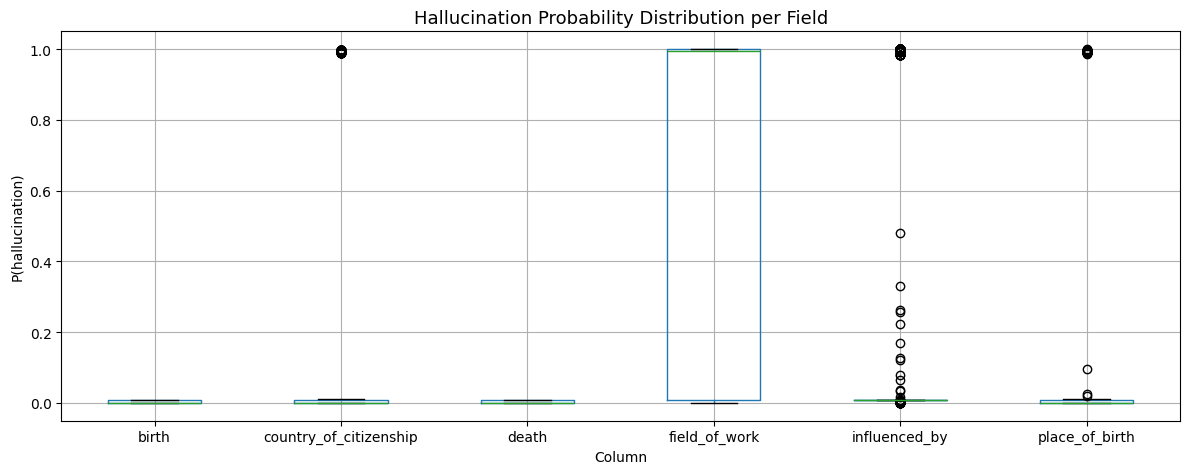

In [12]:
if os.path.exists(CACHE_CLASSIFIER):
    print(f"[CACHE] Loading classifier from {CACHE_CLASSIFIER}")
    with open(CACHE_CLASSIFIER, "rb") as f:
        clf_result = pickle.load(f)
    hall_clf, hall_feat_df = clf_result
else:
    print("Training hallucination classifier...")
    hall_clf, hall_feat_df = train_hallucination_classifier(wiki_df, llm_df, verbose=True)
    with open(CACHE_CLASSIFIER, "wb") as f:
        pickle.dump((hall_clf, hall_feat_df), f)
    print(f"[CACHE] Saved to {CACHE_CLASSIFIER}")

if hall_clf is not None:
    print("\n--- Top 20 most likely hallucinations ---")
    top_hall = (hall_feat_df[hall_feat_df["llm_value_length"] > 0]
                .sort_values("hallucination_probability", ascending=False)
                .head(20)[["philosopher","column","semantic_similarity","hallucination_probability"]])
    print(top_hall.to_string())

    # Plot: hallucination probability distribution per column
    fig, ax = plt.subplots(figsize=(12, 5))
    hall_feat_df.boxplot(column="hallucination_probability", by="column", ax=ax)
    ax.set_title("Hallucination Probability Distribution per Field", fontsize=13)
    ax.set_xlabel("Column")
    ax.set_ylabel("P(hallucination)")
    plt.suptitle("")
    plt.tight_layout()
    plt.savefig("Figs/hallucination_probability_plot.png", dpi=150, bbox_inches="tight")
    plt.show()

## 8. Interpretation & Conclusion

This analysis has compared two fundamentally different approaches to structured knowledge retrieval for philosophers born between 1800 and 1850.

**Key findings:**

1. **Wikidata is exhaustive but sparse.** It returns 1,500+ philosophers but has very low coverage for `influenced_by` (~5%) and `field_of_work` (~25%). It is the right source for completeness and factual anchoring.

2. **The LLM is selective but rich.** For well-known philosophers, the LLM provides high-quality, densely populated records. For obscure figures, it returns empty strings rather than hallucinating. Its `influenced_by` and `field_of_work` coverage is far higher than Wikidata's.

3. **FP-extra is common, especially for set fields.** Many LLM values classified as False Positives are in fact correct — they simply reflect knowledge that Wikidata has not yet recorded. DBpedia cross-validation is essential to distinguish these from genuine hallucinations.

4. **Semantic similarity is a more nuanced metric than binary matching.** The sentence-transformer scores reveal that the LLM often provides semantically equivalent but lexically different values (e.g. `"Prussia"` vs `"Kingdom of Prussia"`), which binary matching would incorrectly penalise.

5. **The hallucination classifier** provides a per-cell risk score that can be used to flag suspicious LLM outputs for manual review, prioritising the most likely errors without requiring exhaustive human annotation.

**Recommended workflow:** Use Wikidata as the primary source for completeness and ground truth. Use the LLM to enrich sparse fields (`influenced_by`, `field_of_work`) for well-known philosophers. Apply the hallucination classifier to flag LLM-enriched values with high hallucination probability before using them in downstream applications.